In [69]:
import pandas as pd
import konlpy
import gensim
import tensorflow as tf

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

# 1. Upload Data

In [32]:
train_data = pd.read_table('sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. Define load_data( ) & Encoding, Decoding functions
- [ ] 데이터의 중복 제거
- [ ] NaN 결측치 제거
- [ ] 한국어 토크나이저로 토큰화
- [ ] 불용어(Stopwords) 제거
- [ ] 사전word_to_index 구성
- [ ] 텍스트 스트링을 사전 인덱스 스트링으로 변환
- [ ] X_train, y_train, X_test, y_test, word_to_index 리턴

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    #Remove duplicated rows
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    #Remove NaN - missing value
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any')
    
    #Return Value
    X_train = []
    X_test = []
    
    #Tokenizer & Remove Stopwords
    for train_sentence in train_data['document']:
        temp_train = tokenizer.morphs(train_sentence)
        temp_train = [word for word in temp_train if word not in stopwords]
        X_train.append(temp_train)

    for test_sentence in test_data['document']:
        temp_test = tokenizer.morphs(test_sentence)
        temp_test = [word for word in temp_test if word not in stopwords]
        X_test.append(temp_test)
    
    # Create word_to_index as a dictionary
    word_to_index = {}
    
    words = set()
    for sentence in X_train:
        for word in sentence:
            words.add(word)
    
    for sentence in X_test:
        for word in sentence:
            words.add(word)
    
    for word in words:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

    X_train_indices = []
    X_test_indices = []
    
    for sentence in X_train:
        X_train_indices.append([word_to_index.get(word) for word in sentence])
    
    for sentence in X_test:
        X_test_indices.append([word_to_index.get(word) for word in sentence])
    
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))
    
    return X_train_indices, y_train, X_test_indices, y_test, word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [55]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)



In [56]:
print("Shpae of list X_train",len(X_train))
print("Shpae of list y_train",len(y_train))
print("Shpae of list X_test",len(X_test))
print("Shpae of list y_test",len(y_test))
print("Shpae of list word_to_index",len(word_to_index))

Shpae of list X_train 146182
Shpae of list y_train 146182
Shpae of list X_test 49157
Shpae of list y_test 49157
Shpae of list word_to_index 10000


In [57]:
print(X_train[0])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


In [49]:
# Function get_encoded_sentence
# Input : One sentence, Word Dictionary
# Return : Index list Vector
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# Function get_encoded_sentences
# Input : Multiple Sentences, Word Dictionary
# Return : call get_encoded_sentence
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# Function get_decoded_sentence
# Input : encoded_sentence, Index Dictionary
# Return : Decoded index vector to original sentence
def get_decoded_sentence(encoded_sentence, bindex_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# Function get_decoded_sentences
# Input : encoded_sentences, Index Dictionary
# Return : call get_deencoded_sentence
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [60]:
index_to_word = {index:word for word, index in word_to_index.items()}

# 3. Preprocessing
- [ ] Check the distribution of sentence lengths
- [ ] Determine the maximum sentenc length
- [ ] Add padding using keras.preprocessing.sequence.pad_sequences

## 3-1. Check the distribution of sentence lengths

In [66]:
total_data = X_train + X_test
num_tokens = [len(tokens) for tokens in total_data]
num_tokens = np.array(num_tokens)

print('AVG sentence lengths : ', np.mean(num_tokens))
print('MAX sentence lengths: ', np.max(num_tokens))
print('SD  sentence lengths: ', np.std(num_tokens))

AVG sentence lengths :  15.96940191154864
MAX sentence lengths:  116
SD  sentence lengths:  12.843571191092


## 3-2. Determine the maximum sentenc length

In [68]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
print('pad_sequences maxlen : ', maxlen)
print(f'{np.sum(num_tokens < max_tokens) / len(num_tokens)}%of the total sentences are included within the maxlen setting. ')

pad_sequences maxlen :  41
0.9342988343341575%of the total sentences are included within the maxlen setting. 


## 3-3. Add padding using keras.preprocessing.sequence.pad_sequences

In [72]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


# 4. Set Model and Validation set

## 4-1. Set Model
### First Model

In [76]:
vocab_size = 10000    
word_vector_dim = 16  

model_01 = tf.keras.Sequential()
model_01.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_01.add(tf.keras.layers.LSTM(8))
model_01.add(tf.keras.layers.Dense(8, activation='relu'))
model_01.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_01.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### Second Model

In [77]:
model_02 = tf.keras.Sequential()
model_02.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_02.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_02.add(tf.keras.layers.MaxPooling1D(5))
model_02.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_02.add(tf.keras.layers.GlobalMaxPooling1D())
model_02.add(tf.keras.layers.Dense(8, activation='relu'))
model_02.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_02.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

### Third Model

In [78]:
model_03 = tf.keras.Sequential()
model_03.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_03.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))  # Bidirectional LSTM
model_03.add(tf.keras.layers.Dense(8, activation='relu'))
model_03.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the summary of the new model
model_03.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                1600      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 161,745
Trainable params: 161,745
Non-trainable params: 0
_________________________________________________________________


## 4-2. Validation Set

In [80]:
##print(X_train.shape) (146182, 41)

x_val = X_train[:40000]   
y_val = y_train[:40000]

partial_x_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


# 5. Train Model

In [82]:
model_01.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
model_02.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_03.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
epochs=40 

history_01 = model_01.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

history_02 = model_02.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

history_03 = model_03.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
208/208 [==============================] - 33s 8ms/step - loss: 0.5173 - accuracy: 0.7710 - val_loss: 0.3756 - val_accuracy: 0.8414
Epoch 2/40
208/208 [==============================] - 1s 6ms/step - loss: 0.3469 - accuracy: 0.8549 - val_loss: 0.3497 - val_accuracy: 0.8496
Epoch 3/40
208/208 [==============================] - 1s 6ms/step - loss: 0.3185 - accuracy: 0.8679 - val_loss: 0.3470 - val_accuracy: 0.8516
Epoch 4/40
208/208 [==============================] - 1s 6ms/step - loss: 0.3023 - accuracy: 0.8758 - val_loss: 0.3538 - val_accuracy: 0.8488
Epoch 5/40
208/208 [==============================] - 1s 6ms/step - loss: 0.2910 - accuracy: 0.8812 - val_loss: 0.3507 - val_accuracy: 0.8502
Epoch 6/40
208/208 [==============================] - 1s 6ms/step - loss: 0.2798 - accuracy: 0.8863 - val_loss: 0.3532 - val_accuracy: 0.8482
Epoch 7/40
208/208 [==============================] - 1s 6ms/step - loss: 0.2700 - accuracy: 0.8911 - val_loss: 0.3650 - val_accuracy: 0.8470
Epoch

208/208 [==============================] - 1s 5ms/step - loss: 0.0392 - accuracy: 0.9889 - val_loss: 0.8693 - val_accuracy: 0.8211
Epoch 19/40
208/208 [==============================] - 1s 5ms/step - loss: 0.0362 - accuracy: 0.9897 - val_loss: 0.9043 - val_accuracy: 0.8198
Epoch 20/40
208/208 [==============================] - 1s 5ms/step - loss: 0.0340 - accuracy: 0.9903 - val_loss: 0.9537 - val_accuracy: 0.8175
Epoch 21/40
208/208 [==============================] - 1s 5ms/step - loss: 0.0317 - accuracy: 0.9909 - val_loss: 1.0089 - val_accuracy: 0.8164
Epoch 22/40
208/208 [==============================] - 1s 5ms/step - loss: 0.0292 - accuracy: 0.9914 - val_loss: 1.0425 - val_accuracy: 0.8134
Epoch 23/40
208/208 [==============================] - 1s 5ms/step - loss: 0.0278 - accuracy: 0.9918 - val_loss: 1.0758 - val_accuracy: 0.8144
Epoch 24/40
208/208 [==============================] - 1s 5ms/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 1.1303 - val_accuracy: 0.8162
Epoch 25/40

208/208 [==============================] - 2s 8ms/step - loss: 0.1143 - accuracy: 0.9586 - val_loss: 0.7346 - val_accuracy: 0.8253
Epoch 36/40
208/208 [==============================] - 2s 8ms/step - loss: 0.1092 - accuracy: 0.9605 - val_loss: 0.7689 - val_accuracy: 0.8249
Epoch 37/40
208/208 [==============================] - 2s 9ms/step - loss: 0.1074 - accuracy: 0.9621 - val_loss: 0.7602 - val_accuracy: 0.8242
Epoch 38/40
208/208 [==============================] - 2s 8ms/step - loss: 0.1037 - accuracy: 0.9633 - val_loss: 0.8140 - val_accuracy: 0.8225
Epoch 39/40
208/208 [==============================] - 2s 8ms/step - loss: 0.1021 - accuracy: 0.9638 - val_loss: 0.8342 - val_accuracy: 0.8245
Epoch 40/40
208/208 [==============================] - 2s 8ms/step - loss: 0.1001 - accuracy: 0.9651 - val_loss: 0.8513 - val_accuracy: 0.8238


In [86]:
results_01 = model_01.evaluate(X_test,  y_test, verbose=2)

results_02 = model_02.evaluate(X_test,  y_test, verbose=2)

results_03 = model_03.evaluate(X_test,  y_test, verbose=2)

print(results_01)

print(results_02)

print(results_03)


1537/1537 - 3s - loss: 0.7894 - accuracy: 0.8236
1537/1537 - 2s - loss: 1.5206 - accuracy: 0.8055
1537/1537 - 4s - loss: 0.8726 - accuracy: 0.8196
[0.789392352104187, 0.8236466646194458]
[1.5205879211425781, 0.805541455745697]
[0.8725547194480896, 0.8195984363555908]


# 6. Loss Accuracy graph

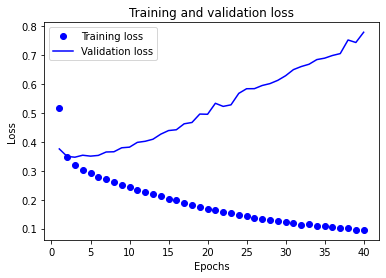

In [87]:
import matplotlib.pyplot as plt


acc = history_dict_01['accuracy']
val_acc = history_dict_01['val_accuracy']
loss = history_dict_01['loss']
val_loss = history_dict_01['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 01')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

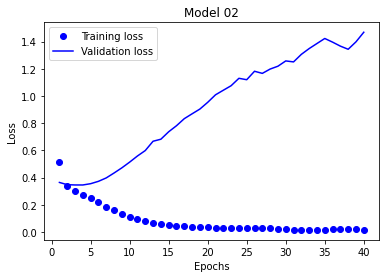

In [88]:
acc = history_dict_02['accuracy']
val_acc = history_dict_02['val_accuracy']
loss = history_dict_02['loss']
val_loss = history_dict_02['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 02')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

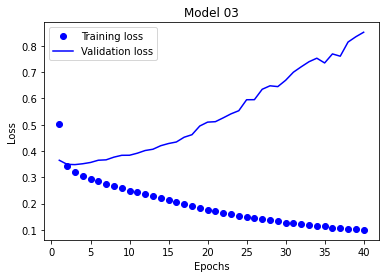

In [89]:
acc = history_dict_03['accuracy']
val_acc = history_dict_03['val_accuracy']
loss = history_dict_03['loss']
val_loss = history_dict_03['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 03')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 6-1. Train Result

### CNN has an overfitting issue
As you can see on the graphs, all of the validation loss are showing an increasing trend.  
Especially, the validation loss of model 2, using CNN, records a highest value and the increasment.  
This suggests that a CNN model may encounter overfitting issues in sequential language data.  
  
### Using RNN
I will use **model 1** because it indicated the highest accuracy and the lowes loss value on the test value set.  

# 7. Verify the Embedding layer is correctly configured

In [90]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/aiffel/AIFEL_Quest/Exploration_04/sentiment_classification/data/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_01.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [91]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('고급', 0.9466866850852966),
 ('샵', 0.9381765127182007),
 ('드셨', 0.9345556497573853),
 ('여운', 0.9324244856834412),
 ('만능', 0.9322518706321716),
 ('깊', 0.9312480092048645),
 ('냉혹', 0.9295480251312256),
 ('귀엽', 0.9265230298042297),
 ('완벽', 0.9220166206359863),
 ('파도', 0.9219453930854797)]

## 7-1. Result of embedding layer
The results from the embedding layer, as observed in the previous cell, indicate that words like '사랑' and others   appear to lack meaningful representations. This suggests that the embedding layer is not effectively capturing   semantic information.

# 8. Improve performence using 한국어 Word2Vec 

In [100]:
temporary_filepath = 'sentiment_classification/data/word2vec_ko.model'
saved_model = gensim.models.Word2Vec.load(temporary_filepath)
word_vectors = saved_model.wv

In [101]:
word_vectors.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [105]:
vocab_size = 10000
word_vector_dim = 100  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)


for i in range(3,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

In [111]:
from tensorflow.keras.initializers import Constant


model_04 = tf.keras.Sequential()
model_04.add(tf.keras.layers.Embedding(vocab_size,
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))
model_04.add(tf.keras.layers.LSTM(8))
model_04.add(tf.keras.layers.Dense(8, activation='relu'))
model_04.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_04.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 1,007,777
Trainable params: 1,007,777
Non-trainable params: 0
_________________________________________________________________


In [112]:
model_04.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model_04.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 3s 8ms/step - loss: 0.5641 - accuracy: 0.7028 - val_loss: 0.4532 - val_accuracy: 0.7912
Epoch 2/20
208/208 [==============================] - 1s 6ms/step - loss: 0.4088 - accuracy: 0.8161 - val_loss: 0.3902 - val_accuracy: 0.8252
Epoch 3/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3593 - accuracy: 0.8425 - val_loss: 0.3734 - val_accuracy: 0.8336
Epoch 4/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3295 - accuracy: 0.8596 - val_loss: 0.3586 - val_accuracy: 0.8443
Epoch 5/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3087 - accuracy: 0.8699 - val_loss: 0.3542 - val_accuracy: 0.8477
Epoch 6/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2918 - accuracy: 0.8788 - val_loss: 0.3553 - val_accuracy: 0.8478
Epoch 7/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2781 - accuracy: 0.8851 - val_loss: 0.3537 - val_accuracy: 0.8486
Epoch 

In [113]:
results = model_04.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4605 - accuracy: 0.8386
[0.4605063498020172, 0.8386394381523132]
